In [220]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 200)
from sklearn.impute import SimpleImputer

In [221]:
import itertools
import collections
from numpy import mean
import nltk
# import KMeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [222]:
#reading in my data frame and replacing spaces and unwanted marks in the columns
county = pd.read_csv('./data/county.csv')
smallcounty = pd.read_csv('./data/smallcounty.csv')
fips = pd.read_csv('./data/countyFIPS.csv')
smallcounty.columns = smallcounty.columns.str.replace(" ", "_")
smallcounty.columns = smallcounty.columns.str.replace("?", "")
fips.columns = fips.columns.str.replace("?", "")
#smallcounty = smallcounty.set_index('name')
county.columns = county.columns.str.replace(" ", "_")
county.columns = county.columns.str.replace("?", "")
fips.columns = fips.columns.str.replace("?", "")
#county = county.set_index('name')
smallcounty.shape

/var/folders/w3/8j3br3pn37q4dc1yqw7571580000gn/T/ipykernel_63720/875246067.py:6: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

/var/folders/w3/8j3br3pn37q4dc1yqw7571580000gn/T/ipykernel_63720/875246067.py:7: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

/var/folders/w3/8j3br3pn37q4dc1yqw7571580000gn/T/ipykernel_63720/875246067.py:10: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

/var/folders/w3/8j3br3pn37q4dc1yqw7571580000gn/T/ipykernel_63720/875246067.py:11: FutureWarning:

The default value of regex will change from Tr

(3142, 15)

In [223]:
#adding the word county to all county names int he FIPS code series
fips.CountyName = fips.CountyName.map(lambda x: x + ' County')

In [224]:
#ignore
recommended = county[['fips', 'state', 'name',
                      'pop_2019', 
                      'per_capita_income_2019', 'native_2017', 'female_2010', 
                      'asian_2017', 'persons_per_household_2019', 
                       'white_not_hispanic_2019', 
                       'veterans_2017', 'two_plus_races_2019',
                      'poverty_2017',  'unemployment_rate_2017', 
                      'uninsured_2017', 'civilian_labor_force_2017', 
                        'avg_family_size_2019', 'bachelors_2019', 
                      'black_2019', 'hispanic_2019', 'household_has_broadband_2019',
                       'households_2019', 'households_speak_limited_english_2019', 
                      'households_speak_spanish_2019', 'housing_mobile_homes_2019', 
                      'housing_one_unit_structures_2019', 'median_age_2019',
                      'median_household_income_2019', 'median_individual_income_2019', 'white_2019']]


In [225]:
#selecting data to use in a recommender system later
'''recommended = county[['fips', 'state', 'name',
                      'pop_2019', 
                        'female_2010',
                       'white_not_hispanic_2019',  
                       'household_has_broadband_2019', 
                       'housing_mobile_homes_2019', 
                      'housing_one_unit_structures_2019', 'median_age_2019',
                       'median_individual_income_2019', 'white_2019', 'median_edu']]'''


"recommended = county[['fips', 'state', 'name',\n                      'pop_2019', \n                        'female_2010',\n                       'white_not_hispanic_2019',  \n                       'household_has_broadband_2019', \n                       'housing_mobile_homes_2019', \n                      'housing_one_unit_structures_2019', 'median_age_2019',\n                       'median_individual_income_2019', 'white_2019', 'median_edu']]"

In [226]:
#sorting all data frame columns by name
fips.sort_values(by=['StateDesc', 'CountyName'],ascending=[True, True], inplace=True)
smallcounty.sort_values(by=['state', 'name'],ascending=[True, True], inplace=True)
recommended.sort_values(by=['state', 'name'], ascending=[True, True], inplace=True)
county.sort_values(by=['state', 'name'],ascending=[True, True], inplace=True)

/opt/homebrew/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [227]:
#addressing null values in all data frames
county.replace('none', np.nan, inplace=True)
county = county.fillna(value=np.nan)
county.fillna(county.mean())

recommended.replace('none', np.nan, inplace=True)
recommended = county.fillna(value=np.nan)
recommended.fillna(county.mean())

smallcounty.replace('none', np.nan, inplace=True)
smallcounty = smallcounty.fillna(value=np.nan)
smallcounty = smallcounty.fillna(smallcounty.mean())
smallcounty['smoking_ban'] = smallcounty['smoking_ban'].map(lambda x: 1 if x == 'partial' else 0)
encodedSmall = pd.get_dummies(smallcounty, columns=['state', 'median_edu', 'metro'])


/var/folders/w3/8j3br3pn37q4dc1yqw7571580000gn/T/ipykernel_63720/1067728686.py:4: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/var/folders/w3/8j3br3pn37q4dc1yqw7571580000gn/T/ipykernel_63720/1067728686.py:8: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/var/folders/w3/8j3br3pn37q4dc1yqw7571580000gn/T/ipykernel_63720/1067728686.py:12: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [228]:
#addressing columns will missing values
smallcounty.dropna(axis=1, how='any', inplace=True)
county.dropna(axis=1, how='any', inplace=True)
recommended.dropna(axis=1, how='any', inplace=True)
county.isnull().sum()

fips                       0
state                      0
name                       0
pop2010                    0
age_under_5_2010           0
                          ..
uninsured_under_19_2019    0
uninsured_under_6_2019     0
veterans_2019              0
white_2019                 0
white_not_hispanic_2019    0
Length: 75, dtype: int64

In [229]:
#detaching the names columns to enable scaling and clustering
reco_names = recommended[['fips', 'name', 'state']]
countynames = county[['fips', 'name', 'state']]
#county.drop(columns=['name', 'fips'], inplace=True)
countynames.shape

(3142, 3)

In [230]:
#Encoding the state column
encodedBig = pd.get_dummies(county, columns=['state'])
encodedBig = encodedBig.drop(columns=['name'])
encodedBig.tail(2)

,fips,pop2010,age_under_5_2010,age_under_18_2010,age_over_65_2010,female_2010,white_2010,two_plus_races_2010,hispanic_2010,white_not_hispanic_2010,no_move_in_one_plus_year_2010,foreign_born_2010,foreign_spoken_at_home_2010,hs_grad_2010,bachelors_2010,veterans_2010,mean_work_travel_2010,housing_units_2010,homeownership_2010,housing_multi_unit_2010,median_val_owner_occupied_2010,households_2010,persons_per_household_2010,per_capita_income_2010,median_household_income_2010,private_nonfarm_establishments_2009,private_nonfarm_employment_2009,building_permits_2010,area_2010,density_2010,poverty_2010,age_over_18_2019,age_over_65_2019,age_over_85_2019,age_under_5_2019,asian_2019,avg_family_size_2019,bachelors_2019,black_2019,hispanic_2019,household_has_broadband_2019,household_has_computer_2019,household_has_smartphone_2019,households_2019,households_speak_asian_or_pac_isl_2019,households_speak_limited_english_2019,households_speak_other_2019,households_speak_other_indo_euro_lang_2019,households_speak_spanish_2019,housing_mobile_homes_2019,housing_one_unit_structures_2019,housing_two_unit_structures_2019,hs_grad_2019,mean_household_income_2019,median_age_2019,median_household_income_2019,median_individual_income_2019,median_individual_income_age_25plus_2019,native_2019,other_single_race_2019,pac_isl_2019,per_capita_income_2019,persons_per_household_2019,pop_2019,two_plus_races_2019,unemployment_rate_2019,uninsured_2019,uninsured_65_and_older_2019,uninsured_under_19_2019,uninsured_under_6_2019,veterans_2019,white_2019,white_not_hispanic_2019,state_Alabama,state_Alaska,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,state_Delaware,state_District of Columbia,state_Florida,state_Georgia,state_Hawaii,state_Idaho,state_Illinois,state_Indiana,state_Iowa,state_Kansas,state_Kentucky,state_Louisiana,state_Maine,state_Maryland,state_Massachusetts,state_Michigan,state_Minnesota,state_Mississippi,state_Missouri,state_Montana,state_Nebraska,state_Nevada,state_New Hampshire,state_New Jersey,state_New Mexico,state_New York,state_North Carolina,state_North Dakota,state_Ohio,state_Oklahoma,state_Oregon,state_Pennsylvania,state_Rhode Island,state_South Carolina,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
3140,56043,8533,7.0,25.5,17.7,50.1,91.4,2.4,13.6,83.9,85.7,3.5,8.3,89.6,24.5,819,12.8,3833,70.9,10.0,130000,3399,2.39,28557,48379,378,3332,1,2238.55,3.8,5.6,75.4,21.1,2.3,5.7,0.0,2.89,23.4,0.0,14.2,78.2,77.2,72.3,3365,0.3,1.2,0.0,1.6,7.8,23.5,11.6,76.5,89.8,65496,42.9,54158,29327,31399,0.9,5.5,0.0,28101,2.34,8027,3.8,4.1,15.0,1.5,7.0,7.8,11.9,89.7,81.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3141,56045,7208,5.7,21.8,15.9,47.4,95.5,1.7,3.0,93.8,84.1,0.8,2.1,91.1,17.9,671,25.2,3533,77.9,6.5,115200,3097,2.19,28463,53853,215,1564,4,2398.09,3.0,7.9,79.0,19.4,2.1,5.6,0.8,2.82,20.0,0.2,1.1,76.8,74.2,74.7,2891,0.9,0.0,0.0,0.2,0.8,17.0,20.1,83.0,93.7,68877,43.1,57031,27367,34728,0.2,0.0,0.1,28531,2.32,7049,1.3,4.0,11.8,0.0,8.6,7.1,10.3,97.4,96.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [231]:
#county.to_csv('./data/county_kmeans_not_encoded.csv')

In [232]:
#scaling my data for clustering
ss = StandardScaler()
encodedScaled = ss.fit_transform(encodedBig)
encodedScaled[:1]


array([[-1.93815729e+00, -1.39633970e-01,  2.90423229e-01,
         1.00136438e+00, -9.26414285e-01,  5.74709813e-01,
        -2.60306851e-01, -2.39766798e-01, -4.46240566e-01,
        -5.50835789e-02,  1.06542907e-01, -4.21550436e-01,
        -4.65334605e-01,  2.98113262e-01,  3.07838274e-01,
        -7.96366976e-02,  4.30408266e-01, -1.61131914e-01,
         5.40635519e-01, -5.51410031e-01,  1.53597657e-02,
        -1.51431213e-01,  7.45051667e-01,  3.81351165e-01,
         7.77858364e-01, -1.86626001e-01, -1.91883696e-01,
        -1.87097861e-03, -1.46662893e-01, -9.70448288e-02,
        -7.67369137e-01, -4.42604392e-01, -8.13841894e-01,
        -7.14351925e-01, -1.35406932e-02, -1.37604575e-01,
         2.86725522e-02,  4.83122471e-01,  6.84452946e-01,
        -4.77420303e-01,  5.88044005e-01,  2.91840906e-01,
         7.24053849e-01, -1.46031007e-01,  3.91684294e-01,
        -3.62245707e-01, -1.54443331e-01, -6.70282981e-01,
        -3.48562877e-01, -2.04962811e-01,  5.43446532e-0

In [233]:
#turning my encoded data back into a data frame
encodedScaled = pd.DataFrame(encodedScaled)
type(encodedScaled)

pandas.core.frame.DataFrame

## CAN KMEANS LEAD TO SOLID RECOMMENDATIONS AND WELL DEFINED CLUSTERS

In [234]:
#setting a KNN clustering algorythm 
kmeans = KMeans(n_clusters=63, random_state=55)
kmeans.fit(encodedScaled)
silhouette_score(encodedScaled, kmeans.labels_)

0.31901152270460337

In [235]:
#calling a number of helpful labels & metrics for kmeans to make sure the model fitted correctly
encodedScaled['labels'] = kmeans.labels_
kmeans.cluster_centers_
kmeans.inertia_
kmeans.labels_
kmeans.n_iter_

13

In [236]:
#reattaching column names and adding a column for cluster numbers
encodedBig = pd.concat([countynames, encodedBig], axis=1, ignore_index=False)
encodedBig = encodedBig.rename(columns={0: 'fips', 1: 'name', 2: 'state'})
encodedBig['kmeans'] = kmeans.labels_
county['kmeans'] = kmeans.labels_

In [237]:
#viewing the number rof counties in the smallest clusters
county['kmeans'].value_counts().head(3)

6    144
3    127
7    110
Name: kmeans, dtype: int64

In [238]:
#visualizing the top fives clusters with the biggest populations
county.groupby('kmeans')['pop_2019'].mean().sort_values(ascending=False).head(3)

kmeans
15    6.063821e+06
35    1.986106e+06
13    1.669044e+06
Name: pop_2019, dtype: float64

<AxesSubplot:ylabel='kmeans'>

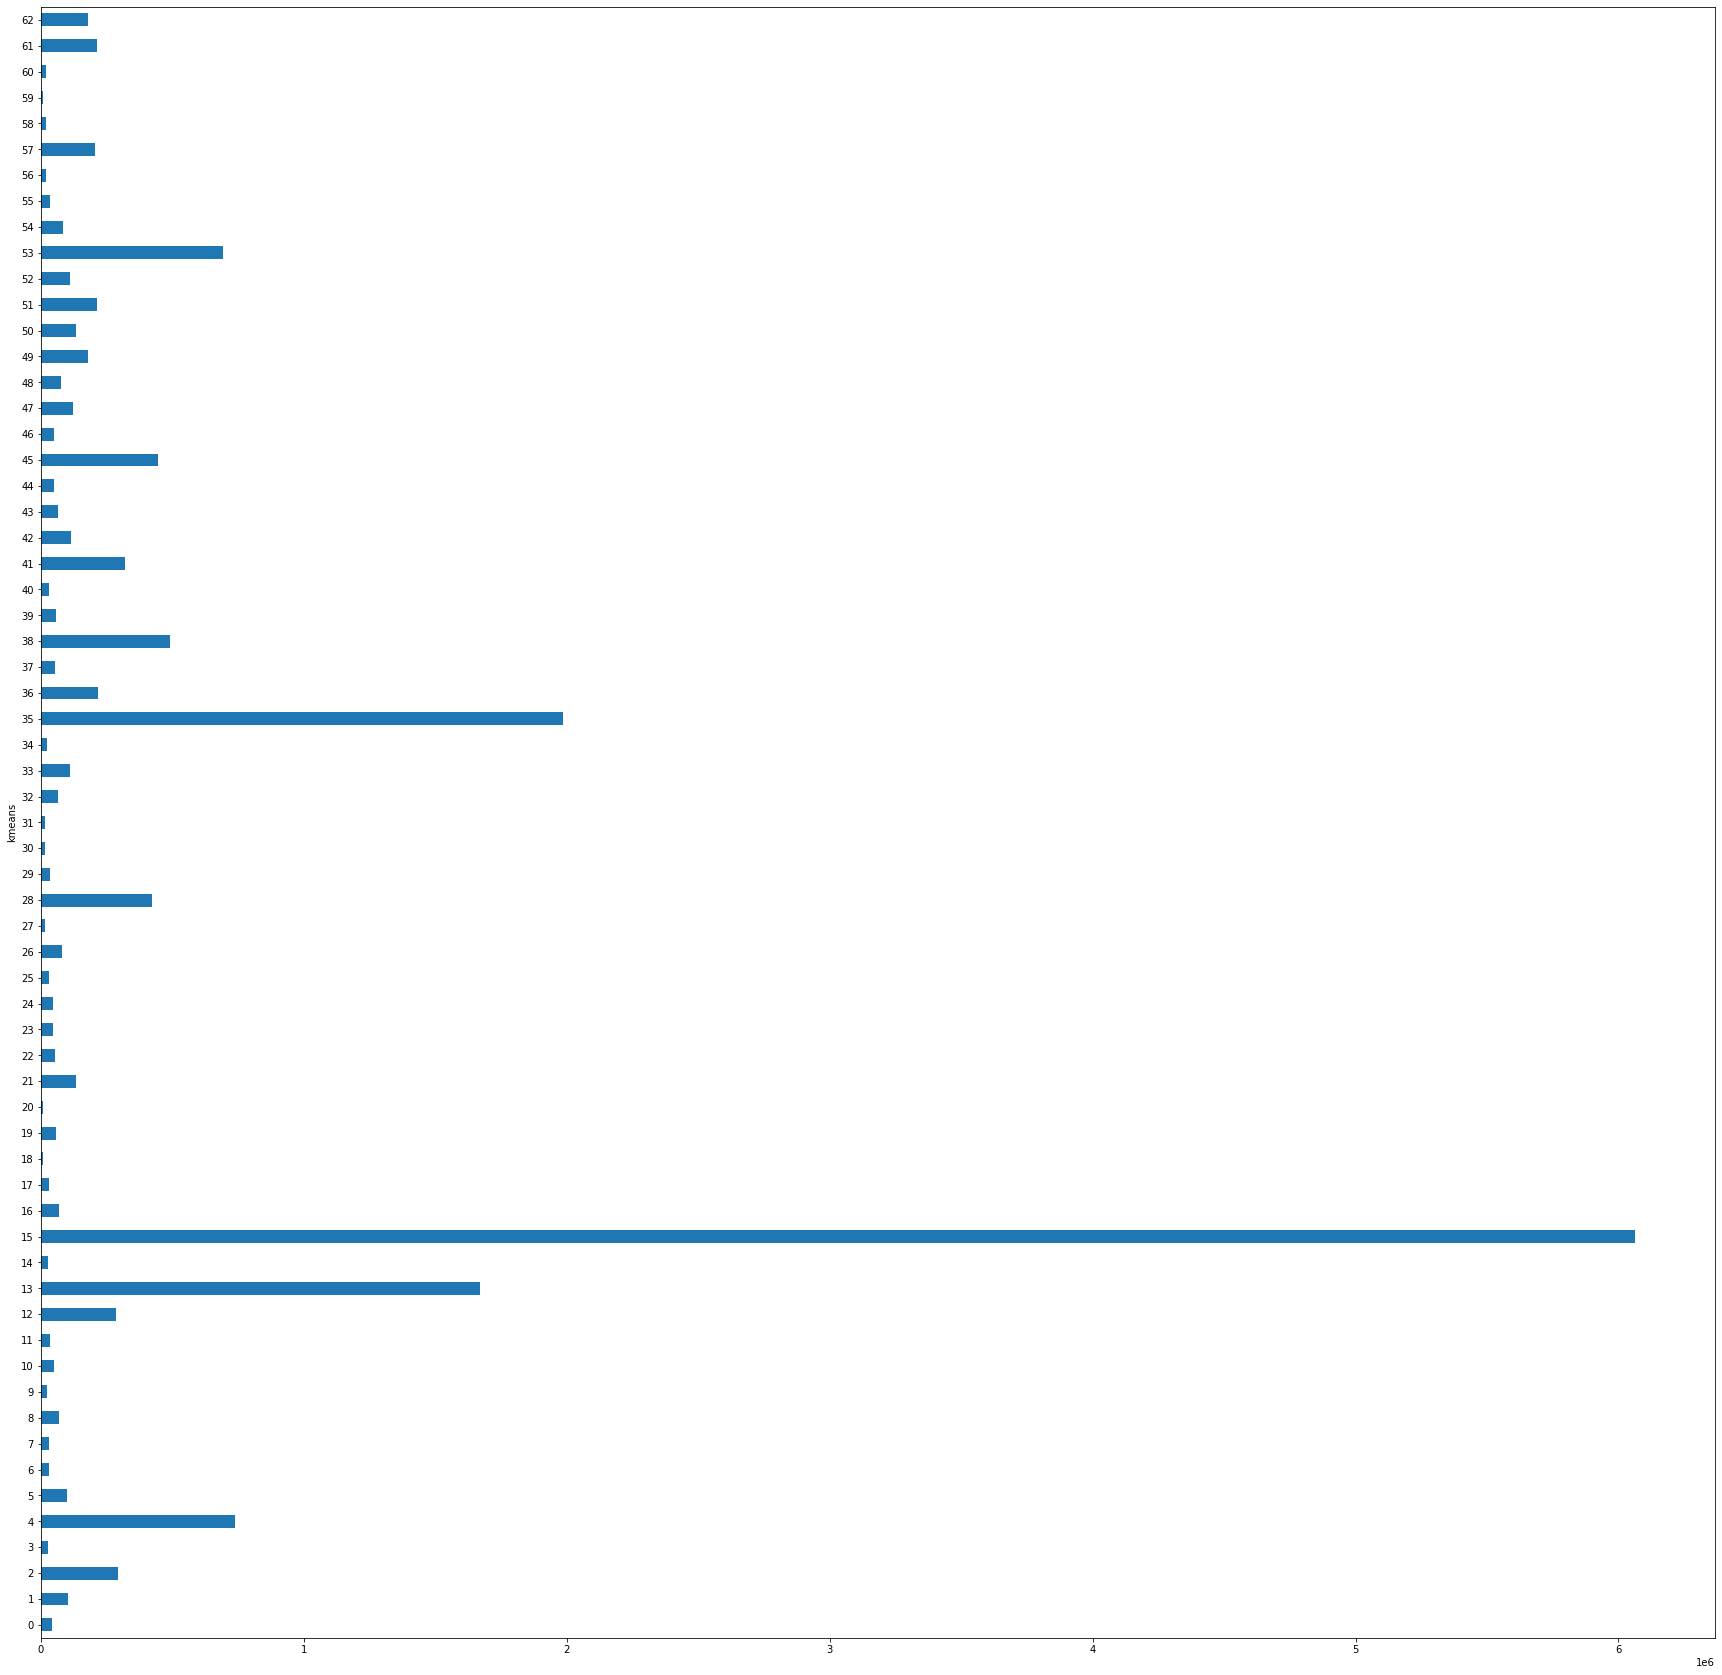

In [239]:
#visualizing mean population by cluster
county.groupby('kmeans')['pop_2019'].mean().plot(kind='barh', figsize=(30,30))

In [240]:
from sklearn.decomposition import PCA
import plotly.express as px

In [242]:
fig = px.scatter_3d(county, x='median_individual_income_2019',
y='household_has_broadband_2019', z='bachelors_2019', color='kmeans', opacity=0.6, 
labels={'kmeans': 'Cluster Number', 'household_has_broadband_2019': "broadband", 'median_individual_income_2019': 'Income', 'bachelors_2019':'University'})
fig.show()

/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



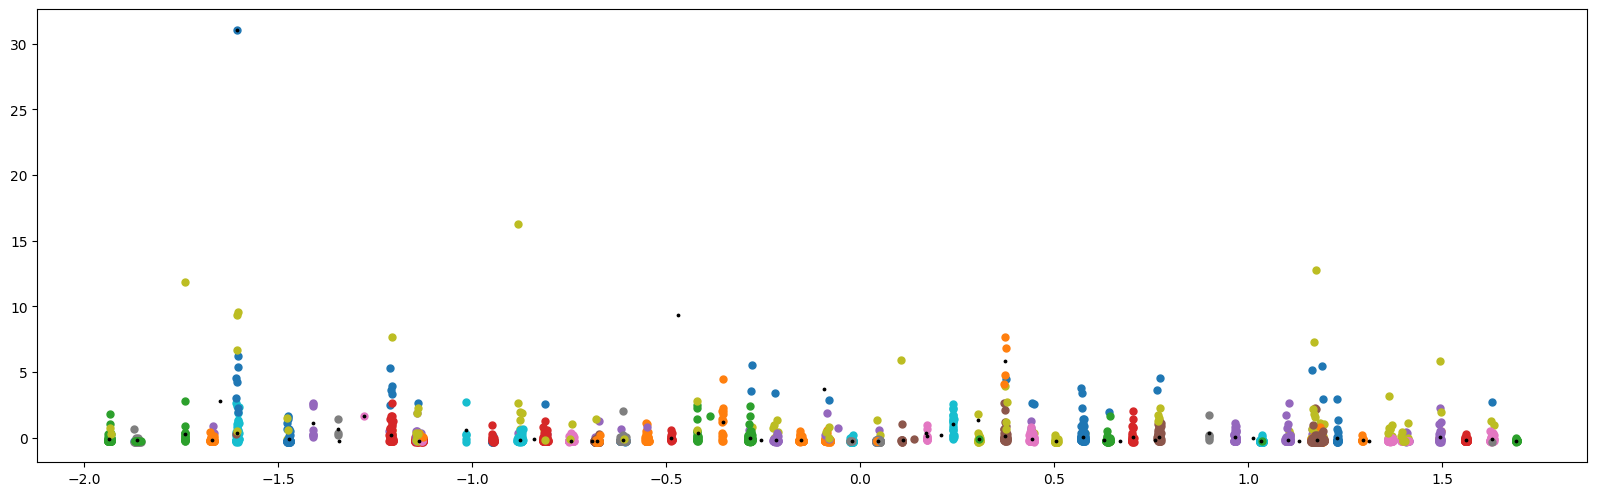

In [243]:
#visualizing the centroids for each cluster on a 2d plane
label = kmeans.fit_predict(encodedScaled)

pd.DataFrame(label)
u_labels = np.unique(label)
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)

X = np.array(encodedScaled)  # that all
#plotting the results:
plt.figure(figsize=(20, 6), dpi=100)
for i in u_labels:
    plt.scatter(X[label == i, 0],X[label == i, 1], label=i, s=25)
#plt.figure(figsize=(8, 8), dpi=80)

plt.scatter(centroids[:, 0], centroids[:, 1], s=3, color='k')
#plt.legend()
#plt.figure(figsize=(8, 8), dpi=80)
plt.show()

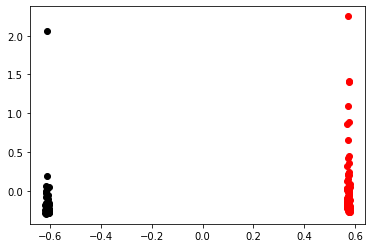

In [244]:
#justaposing the highest and lowest density clusters
filtered_label2 = X[label == 20]
filtered_label8 = X[label == 7]
#Plotting the results
plt.scatter(filtered_label2[:, 0], filtered_label2[:, 1], color='red')
plt.scatter(filtered_label8[:, 0], filtered_label8[:, 1], color='black')
plt.show()


In [245]:
#limiting to see only cluster 20
county[county['kmeans'] == 26].head(2)


,fips,state,name,pop2010,age_under_5_2010,age_under_18_2010,age_over_65_2010,female_2010,white_2010,two_plus_races_2010,hispanic_2010,white_not_hispanic_2010,no_move_in_one_plus_year_2010,foreign_born_2010,foreign_spoken_at_home_2010,hs_grad_2010,bachelors_2010,veterans_2010,mean_work_travel_2010,housing_units_2010,homeownership_2010,housing_multi_unit_2010,median_val_owner_occupied_2010,households_2010,persons_per_household_2010,per_capita_income_2010,median_household_income_2010,private_nonfarm_establishments_2009,private_nonfarm_employment_2009,building_permits_2010,area_2010,density_2010,poverty_2010,age_over_18_2019,age_over_65_2019,age_over_85_2019,age_under_5_2019,asian_2019,avg_family_size_2019,bachelors_2019,black_2019,hispanic_2019,household_has_broadband_2019,household_has_computer_2019,household_has_smartphone_2019,households_2019,households_speak_asian_or_pac_isl_2019,households_speak_limited_english_2019,households_speak_other_2019,households_speak_other_indo_euro_lang_2019,households_speak_spanish_2019,housing_mobile_homes_2019,housing_one_unit_structures_2019,housing_two_unit_structures_2019,hs_grad_2019,mean_household_income_2019,median_age_2019,median_household_income_2019,median_individual_income_2019,median_individual_income_age_25plus_2019,native_2019,other_single_race_2019,pac_isl_2019,per_capita_income_2019,persons_per_household_2019,pop_2019,two_plus_races_2019,unemployment_rate_2019,uninsured_2019,uninsured_65_and_older_2019,uninsured_under_19_2019,uninsured_under_6_2019,veterans_2019,white_2019,white_not_hispanic_2019,kmeans
1231,26001,Michigan,Alcona County,10942,3.0,14.6,31.4,49.2,97.9,0.9,1.1,97.1,92.5,1.5,2.2,84.3,12.4,1816,23.9,11073,90.2,1.1,119300,4608,2.43,19904,34858,195,1004,20,674.59,16.2,14.6,87.0,35.8,3.9,3.1,0.2,2.52,16.9,0.4,1.5,71.6,67.0,63.5,4988,0.7,0.4,0.2,0.9,1.6,11.2,8.1,88.8,89.3,52435,58.2,40484,23311,26374,0.6,0.3,0.1,25636,2.05,10353,1.5,7.4,4.6,0.0,1.5,0.0,14.7,96.9,95.8,26
1232,26003,Michigan,Alger County,9601,3.9,17.1,20.6,45.6,86.3,2.7,1.2,85.5,85.8,2.6,4.5,86.2,16.9,1179,18.4,6554,81.7,7.9,111500,3688,2.24,19858,38262,228,1735,35,915.07,10.5,12.3,84.9,24.7,3.6,3.6,0.1,3.40,17.4,7.7,1.6,74.4,73.0,53.9,3007,0.1,0.0,0.8,0.7,1.5,16.0,4.9,84.0,89.9,55675,49.5,45570,22430,24782,3.6,0.1,0.0,20851,2.70,9151,3.5,5.6,8.3,2.6,5.8,2.6,10.9,84.9,83.6,26


In [472]:
#building a list of different silhouette scores to visualize and identify the best pick
silhouette_list = []

for k in range(2, 100):
    kmeans = KMeans(n_clusters=k, random_state=12)
    kmeans.fit(encodedScaled)
    silhouette_list.append(silhouette_score(encodedScaled, kmeans.labels_))
silhouette_list[0]

/Users/airtonkamdem/.pyenv/versions/3.9.4/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/airtonkamdem/.pyenv/versions/3.9.4/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/airtonkamdem/.pyenv/versions/3.9.4/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/airtonkamdem/.pyenv/versions/3.9.4/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature name

0.45637378530098804

Text(0.5, 1.0, 'Silhouette Scores for County Clusters')

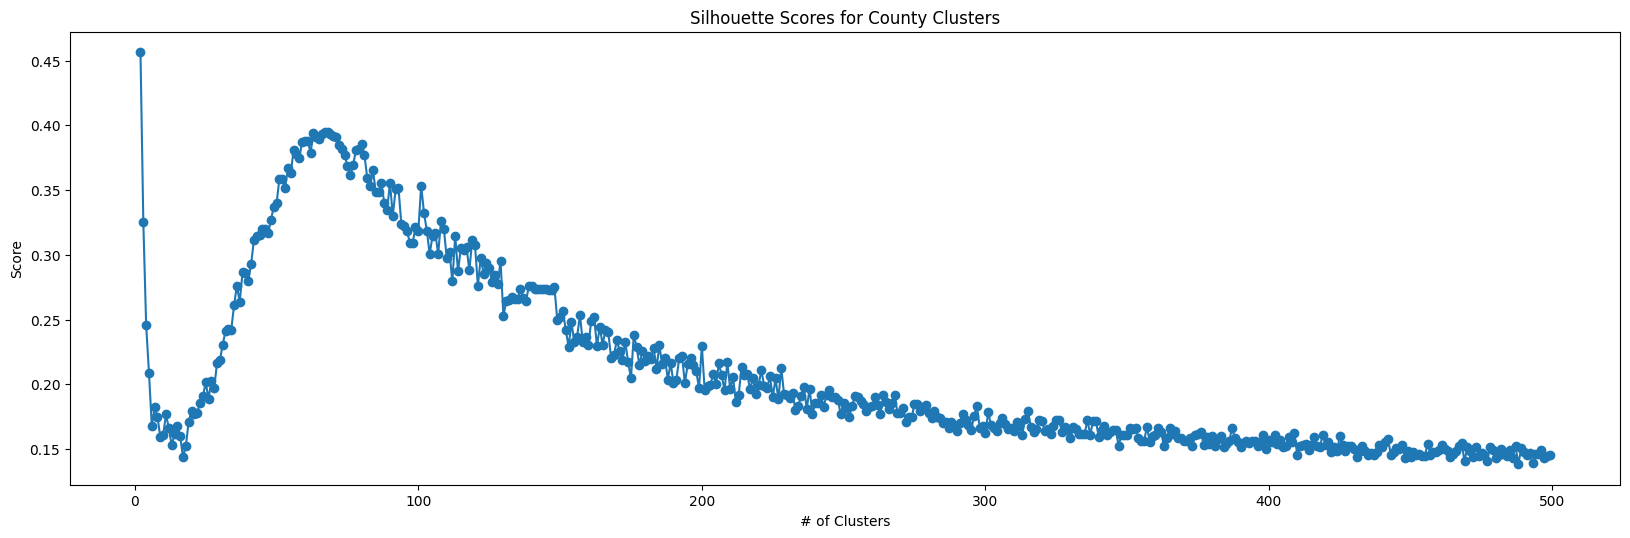

In [473]:
#plotting silhouette scores and their k values
plt.figure(figsize=(20, 6), dpi=100)
plt.plot(range(2, 500), silhouette_list[:501], marker='o')
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Silhouette Scores for County Clusters')

# BUILDING A RECOMMENDER SYSTEM WITH COSINE SIMILARITIES

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity, cosine_distances

In [250]:
#Scaling and viewing the target data
ss = StandardScaler()
reco_scaled = ss.fit_transform(recommended.drop(columns=['name', 'state']))
reco_scaled[:1]

array([[-1.93815729e+00, -1.39633970e-01,  2.90423229e-01,
         1.00136438e+00, -9.26414285e-01,  5.74709813e-01,
        -2.60306851e-01, -2.39766798e-01, -4.46240566e-01,
        -5.50835789e-02,  1.06542907e-01, -4.21550436e-01,
        -4.65334605e-01,  2.98113262e-01,  3.07838274e-01,
        -7.96366976e-02,  4.30408266e-01, -1.61131914e-01,
         5.40635519e-01, -5.51410031e-01,  1.53597657e-02,
        -1.51431213e-01,  7.45051667e-01,  3.81351165e-01,
         7.77858364e-01, -1.86626001e-01, -1.91883696e-01,
        -1.87097861e-03, -1.46662893e-01, -9.70448288e-02,
        -7.67369137e-01, -4.42604392e-01, -8.13841894e-01,
        -7.14351925e-01, -1.35406932e-02, -1.37604575e-01,
         2.86725522e-02,  4.83122471e-01,  6.84452946e-01,
        -4.77420303e-01,  5.88044005e-01,  2.91840906e-01,
         7.24053849e-01, -1.46031007e-01,  3.91684294e-01,
        -3.62245707e-01, -1.54443331e-01, -6.70282981e-01,
        -3.48562877e-01, -2.04962811e-01,  5.43446532e-0

In [251]:
#applying cosine similarities, distances, and pairwise distance
cs = cosine_similarity(reco_scaled)
pair = pairwise_distances(reco_scaled)
cd = cosine_distances(reco_scaled)

In [252]:
#turning my encoded data back into a data frame
recommended = pd.DataFrame(reco_scaled)
recommended.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72
0,-1.938157,-0.139634,0.290423,1.001364,-0.926414,0.574710,-0.260307,-0.239767,-0.446241,-0.055084,0.106543,-0.421550,-0.465335,0.298113,0.307838,-0.079637,0.430408,-0.161132,0.540636,-0.551410,0.015360,-0.151431,0.745052,0.381351,0.777858,-0.186626,-0.191884,-0.001871,-0.146663,-0.097045,-0.767369,-0.442604,-0.813842,-0.714352,-0.013541,-0.137605,0.028673,0.483122,0.684453,-0.477420,0.588044,0.291841,0.724054,-0.146031,0.391684,-0.362246,-0.154443,-0.670283,-0.348563,-0.204963,0.543447,0.204959,0.247866,0.295933,-0.596289,0.370331,0.348184,0.725093,-0.216629,-0.357842,-0.152028,0.25751,0.168610,-0.144846,-0.124654,-0.547769,-0.497164,-0.542476,-0.884001,-0.652358,1.503413,-0.361994,-0.081624
1,-1.938025,0.268469,-0.137503,-0.124723,0.219304,0.484596,0.166880,-0.303453,-0.294613,0.261697,-0.590561,-0.137267,-0.309040,0.610745,0.896549,0.754183,0.557365,0.506202,0.438473,1.106514,0.505411,0.301420,-0.052140,0.732835,0.508666,0.307525,0.126959,0.886695,0.128950,-0.083821,-0.516736,0.153857,0.260151,-0.388402,-0.251665,-0.173313,0.507870,1.036779,0.015633,-0.347582,0.723710,0.626937,1.137060,0.364285,-0.213069,-0.203721,-0.211139,-0.050486,-0.195303,-0.432598,-0.072121,0.432594,0.615169,0.621421,0.289842,0.341367,0.361248,0.298050,-0.152536,-0.254852,-0.152028,0.67147,0.277274,0.330665,-0.377209,-0.358222,-0.144698,-0.215826,-0.464859,-0.565041,1.197297,0.194425,0.338906


In [253]:
#reattaching my column names back to the data frame
recommended = pd.concat([reco_names, recommended], axis=1, ignore_index=True)
recommended.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75
0,1001,Autauga County,Alabama,-1.938157,-0.139634,0.290423,1.001364,-0.926414,0.574710,-0.260307,-0.239767,-0.446241,-0.055084,0.106543,-0.421550,-0.465335,0.298113,0.307838,-0.079637,0.430408,-0.161132,0.540636,-0.551410,0.015360,-0.151431,0.745052,0.381351,0.777858,-0.186626,-0.191884,-0.001871,-0.146663,-0.097045,-0.767369,-0.442604,-0.813842,-0.714352,-0.013541,-0.137605,0.028673,0.483122,0.684453,-0.477420,0.588044,0.291841,0.724054,-0.146031,0.391684,-0.362246,-0.154443,-0.670283,-0.348563,-0.204963,0.543447,0.204959,0.247866,0.295933,-0.596289,0.370331,0.348184,0.725093,-0.216629,-0.357842,-0.152028,0.25751,0.168610,-0.144846,-0.124654,-0.547769,-0.497164,-0.542476,-0.884001,-0.652358,1.503413,-0.361994,-0.081624
1,1003,Baldwin County,Alabama,-1.938025,0.268469,-0.137503,-0.124723,0.219304,0.484596,0.166880,-0.303453,-0.294613,0.261697,-0.590561,-0.137267,-0.309040,0.610745,0.896549,0.754183,0.557365,0.506202,0.438473,1.106514,0.505411,0.301420,-0.052140,0.732835,0.508666,0.307525,0.126959,0.886695,0.128950,-0.083821,-0.516736,0.153857,0.260151,-0.388402,-0.251665,-0.173313,0.507870,1.036779,0.015633,-0.347582,0.723710,0.626937,1.137060,0.364285,-0.213069,-0.203721,-0.211139,-0.050486,-0.195303,-0.432598,-0.072121,0.432594,0.615169,0.621421,0.289842,0.341367,0.361248,0.298050,-0.152536,-0.254852,-0.152028,0.67147,0.277274,0.330665,-0.377209,-0.358222,-0.144698,-0.215826,-0.464859,-0.565041,1.197297,0.194425,0.338906


In [254]:
#renaming my country and fips columns
recommended = recommended.rename(columns={0: 'fips', 1: 'name', 2:'state'})

In [255]:
#inputting counties for recommendation
countyInput = 'Orange County'
stateInput = 'California'
state = recommended[recommended['state'] == stateInput]
countyIndex = state[recommended.name == countyInput].index.values[0]
countyIndex

/var/folders/w3/8j3br3pn37q4dc1yqw7571580000gn/T/ipykernel_63720/1606896274.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



215

In [256]:
#creating a list of cosine scores to pick from 
scores = list(enumerate(cs[int(countyIndex)]))
scores_PD = list(enumerate(pair[countyIndex]))
score_CD = list(enumerate(cd[countyIndex]))

In [257]:
#creating a sorted array with each index and its cosine similarity score and reversing to return the shorted distances first
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
sorted_scores_PD = sorted(scores_PD, key=lambda x: x[1], reverse=False)
sorted_scores_CD = sorted(score_CD, key=lambda x: x[1], reverse=False)

In [258]:
#the first value is just a similarity score against itself so we skip it
print(cs)

[[ 1.          0.55498617 -0.06765172 ...  0.31090569 -0.10301159
   0.03112218]
 [ 0.55498617  1.         -0.36902071 ...  0.05161294 -0.0577935
   0.09140959]
 [-0.06765172 -0.36902071  1.         ... -0.39606642 -0.45530176
  -0.41299156]
 ...
 [ 0.31090569  0.05161294 -0.39606642 ...  1.          0.33546024
   0.25990341]
 [-0.10301159 -0.0577935  -0.45530176 ...  0.33546024  1.
   0.47176982]
 [ 0.03112218  0.09140959 -0.41299156 ...  0.25990341  0.47176982
   1.        ]]


In [259]:
#Skipping the first prediction since this will be equal to 1 as seen above
sorted_scores = sorted_scores[1:]
sorted_scores_PD = sorted_scores_PD[1:]
sorted_scores_CD = sorted_scores_CD[1:]

## Cosine Similarity

In [260]:
recommended.head(2)

,fips,name,state,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75
0,1001,Autauga County,Alabama,-1.938157,-0.139634,0.290423,1.001364,-0.926414,0.574710,-0.260307,-0.239767,-0.446241,-0.055084,0.106543,-0.421550,-0.465335,0.298113,0.307838,-0.079637,0.430408,-0.161132,0.540636,-0.551410,0.015360,-0.151431,0.745052,0.381351,0.777858,-0.186626,-0.191884,-0.001871,-0.146663,-0.097045,-0.767369,-0.442604,-0.813842,-0.714352,-0.013541,-0.137605,0.028673,0.483122,0.684453,-0.477420,0.588044,0.291841,0.724054,-0.146031,0.391684,-0.362246,-0.154443,-0.670283,-0.348563,-0.204963,0.543447,0.204959,0.247866,0.295933,-0.596289,0.370331,0.348184,0.725093,-0.216629,-0.357842,-0.152028,0.25751,0.168610,-0.144846,-0.124654,-0.547769,-0.497164,-0.542476,-0.884001,-0.652358,1.503413,-0.361994,-0.081624
1,1003,Baldwin County,Alabama,-1.938025,0.268469,-0.137503,-0.124723,0.219304,0.484596,0.166880,-0.303453,-0.294613,0.261697,-0.590561,-0.137267,-0.309040,0.610745,0.896549,0.754183,0.557365,0.506202,0.438473,1.106514,0.505411,0.301420,-0.052140,0.732835,0.508666,0.307525,0.126959,0.886695,0.128950,-0.083821,-0.516736,0.153857,0.260151,-0.388402,-0.251665,-0.173313,0.507870,1.036779,0.015633,-0.347582,0.723710,0.626937,1.137060,0.364285,-0.213069,-0.203721,-0.211139,-0.050486,-0.195303,-0.432598,-0.072121,0.432594,0.615169,0.621421,0.289842,0.341367,0.361248,0.298050,-0.152536,-0.254852,-0.152028,0.67147,0.277274,0.330665,-0.377209,-0.358222,-0.144698,-0.215826,-0.464859,-0.565041,1.197297,0.194425,0.338906


In [261]:
#setting a function to return the most similar counties
def similar_county(countyInput, stateInput):
    state = recommended[recommended['state'] == stateInput]
    countyIndex = state[recommended.name == countyInput].index.values[0]
    scores = list(enumerate(cs[int(countyIndex)]))
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    sorted_scores = sorted_scores[1:]

    j = 0
    print("Hmmm, it looks like you enjoy",
          countyInput, ',', stateInput, '-- you may also be fond of:\n')

    for item in sorted_scores:
        similar_d = item[0]
        distance = item[1]
        county_ = recommended.iloc[similar_d][['name', 'state']].values[0]
        state_ = recommended.iloc[similar_d][['name', 'state']].values[1]

        print(j+1, ')', county_, ',', state_,
              'since it has a Cosine Similarity score of', round(distance, 3), 'out of 1')
        j = j+1
        if j > 10:
            break

In [262]:
#calling the function to return the top 5 most similar counties
similar_county(countyInput, stateInput)

Hmmm, it looks like you enjoy Orange County , California -- you may also be fond of:

1 ) San Diego County , California since it has a Cosine Similarity score of 0.955 out of 1
2 ) King County , Washington since it has a Cosine Similarity score of 0.925 out of 1
3 ) Sacramento County , California since it has a Cosine Similarity score of 0.92 out of 1
4 ) Los Angeles County , California since it has a Cosine Similarity score of 0.919 out of 1
5 ) Cook County , Illinois since it has a Cosine Similarity score of 0.908 out of 1
6 ) Douglas County , Nevada since it has a Cosine Similarity score of 0.904 out of 1
7 ) Hennepin County , Minnesota since it has a Cosine Similarity score of 0.891 out of 1
8 ) Dallas County , Texas since it has a Cosine Similarity score of 0.888 out of 1
9 ) Middlesex County , Massachusetts since it has a Cosine Similarity score of 0.886 out of 1
10 ) Orange County , Florida since it has a Cosine Similarity score of 0.884 out of 1
11 ) Broward County , Florida si

/var/folders/w3/8j3br3pn37q4dc1yqw7571580000gn/T/ipykernel_63720/1256878862.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



# SCRAP CODE

In [491]:
def similar(countyInput, stateInput):
    state = recommended[recommended['state'] == stateInput]
    countyIndex = state[recommended.name == countyInput].index.values[0]
    scores = list(enumerate(cs[int(countyIndex)]))
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    sorted_scores = sorted_scores[1:]

    j = 0
    #print("Hmmm, it looks like you enjoy",
    #      countyInput, ',', stateInput, '-- you may also be fond of:\n')
    output = []
    for item in sorted_scores:
        itemIndex = item[0]
        sim_score = item[1]
        county_ = recommended.iloc[itemIndex][['name', 'state']].values[0]
        state_ = recommended.iloc[itemIndex][['name', 'state']].values[1]
        output.append(county_+', ' + state_)
        output.append(sim_score)
        #output = "Based on Cosine Similarities, the 5 most recommended counties to " + countyInput + ',' stateInput + 'is' listed[0]
        j = j+1
        if j > 10:
            break
    return output


similar(countyInput, stateInput)


/var/folders/w3/8j3br3pn37q4dc1yqw7571580000gn/T/ipykernel_11096/2549578713.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  countyIndex = state[recommended.name == countyInput].index.values[0]


['San Diego County, California',
 0.9554783355263368,
 'King County, Washington',
 0.9250423669109882,
 'Sacramento County, California',
 0.9204023274014914,
 'Los Angeles County, California',
 0.918644773883937,
 'Cook County, Illinois',
 0.9081180835631635,
 'Douglas County, Nevada',
 0.9035381710364763,
 'Hennepin County, Minnesota',
 0.890759717417731,
 'Dallas County, Texas',
 0.8879867596123961,
 'Middlesex County, Massachusetts',
 0.8845052439213212,
 'Orange County, Florida',
 0.8842903940057968,
 'Broward County, Florida',
 0.8832682483110653]

In [492]:
'''state = recommended[recommended['state'] == 'California']
#countyIndex = state[recommended.name == 'Orange County'].index.values[0]
#state[state['name'] == 'Orange County'].index.values[0]
state'''


"state = recommended[recommended['state'] == 'California']\n#countyIndex = state[recommended.name == 'Orange County'].index.values[0]\n#state[state['name'] == 'Orange County'].index.values[0]\nstate"

In [493]:
def similar_county(countyInput, stateInput):
    state = recommended[recommended['state'] == stateInput]
    countyIndex = state[state.name == countyInput].index.values[0]
    scores = list(enumerate(cs[int(countyIndex)]))
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    sorted_scores = sorted_scores[1:]

    j = 0
    #print("Hmmm, it looks like you enjoy",
    #      countyInput, ',', stateInput, '-- you may also be fond of:\n')
    outputscore = []
    output_place = []
    for item in sorted_scores:
        itemIndex = item[0]
        sim_score = item[1]
        county_ = recommended.iloc[itemIndex][['name', 'state']].values[0]
        state_ = recommended.iloc[itemIndex][['name', 'state']].values[1]
        output_place.append(county_+', ' + state_)
        outputscore.append(sim_score)
        #output = "Based on Cosine Similarities, the 5 most recommended counties to " + countyInput + ',' stateInput + 'is' listed[0]
        j = j+1
        if j > 10:
            break
    return pd.DataFrame({'place': output_place, 'score': outputscore})


similar_county('Montgomery County', 'Maryland')


,place,score
0,"Washington County, Maryland",0.859229
1,"San Juan County, Washington",0.809696
2,"Barnstable County, Massachusetts",0.806961
3,"Nevada County, California",0.789404
4,"Cape May County, New Jersey",0.788437
5,"Carroll County, New Hampshire",0.787305
6,"Columbia County, New York",0.783096
7,"Patrick County, Virginia",0.775855
8,"Berkshire County, Massachusetts",0.773748
9,"Jefferson County, Washington",0.766993


#### SCRAP

In [495]:
#second version

def similar_county(countyInput, stateInput):
    state = recommended[recommended['state'] == stateInput]
    countyIndex = state[recommended.name == countyInput].index.values[0]
    scores = list(enumerate(cs[int(countyIndex)]))
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    sorted_scores = sorted_scores[1:]

    j = 0
    #print("Hmmm, it looks like you enjoy",
    #      countyInput, ',', stateInput, '-- you may also be fond of:\n')
    output = []
    for item in sorted_scores:
        itemIndex = item[0]
        sim_score = item[1]
        county_ = recommended.iloc[itemIndex][['name', 'state']].values[0]
        state_ = recommended.iloc[itemIndex][['name', 'state']].values[1]
        output.append(county_+', ' + state_)
        output.append(sim_score)
        #output = "Based on Cosine Similarities, the 5 most recommended counties to " + countyInput + ',' stateInput + 'is' listed[0]
        j = j+1
        if j > 10:
            break
    return output


model = similar_county(countyInput, stateInput)



/var/folders/w3/8j3br3pn37q4dc1yqw7571580000gn/T/ipykernel_11096/2390798910.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  countyIndex = state[recommended.name == countyInput].index.values[0]


In [496]:
def similar_county(countyInput, stateInput):
    state = recommended[recommended['state'] == stateInput]
    countyIndex = state[state['name'] == countyInput].index.values[0]
    scores = list(enumerate(cs[int(countyIndex)]))
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    sorted_scores = sorted_scores[1:]

    j = 0
    #print("Hmmm, it looks like you enjoy",
    #      countyInput, ',', stateInput, '-- you may also be fond of:\n')
    outputscore = []
    output_place = []
    for item in sorted_scores:
        itemIndex = item[0]
        sim_score = item[1]
        county_ = recommended.iloc[itemIndex][['name', 'state']].values[0]
        state_ = recommended.iloc[itemIndex][['name', 'state']].values[1]
        output_place.append(county_+', ' + state_)
        outputscore.append(sim_score)
        #output = "Based on Cosine Similarities, the 5 most recommended counties to " + countyInput + ',' stateInput + 'is' listed[0]
        j = j+1
        if j > 10:
            break
    return pd.DataFrame({'place': output_place, 'score': outputscore})


similar_county('Orange County', "California")


,place,score
0,"San Diego County, California",0.955478
1,"King County, Washington",0.925042
2,"Sacramento County, California",0.920402
3,"Los Angeles County, California",0.918645
4,"Cook County, Illinois",0.908118
5,"Douglas County, Nevada",0.903538
6,"Hennepin County, Minnesota",0.890760
7,"Dallas County, Texas",0.887987
8,"Middlesex County, Massachusetts",0.884505
9,"Orange County, Florida",0.884290


In [ ]:
'''smallcounty.dropna(inplace=True)
smallcounty.shape
with open("county.pkl", "wb") as file:
    pickle.dump(model, file)
smallcounty['smoking_ban'] = smallcounty['smoking_ban'].map(lambda x: 1 if x == 'partial' else 0)
smallcounty['smoking_ban'].head()'''
#county.dropna(inplace=True)
#county.shape
'''bigcounty = bigcounty.fillna(value=np.nan)
bigcounty.replace('none', np.nan, inplace=True)
bigcounty.fillna(bigcounty.mean())'''
'''# ---Applying Only on variables with NaN values
for i in bigcounty.columns[bigcounty.isnull().any(axis=0)]:
    bigcounty[i].fillna(bigcounty[i].mean(),inplace=True)'''
#county = county.select_dtypes(include=['float64', 'int64']).head(2)
'''impute = SimpleImputer(missing_values=np.nan, strategy='mean')
df = impute.fit_transform(county.drop(columns=['state', 'smoking_ban', 'name', 'median_edu', 'metro']))
df = pd.DataFrame(df)
df.head()'''
#bigcounty.to_csv('./data/bigcounty_tableau.csv')
#county.to_csv('./data/bigcounty_filled.csv')
#df2.columns = df2.drop(columns=['state', 'smoking_ban', 'name', 'median_edu', 'metro']).columns
#smallcounty.head()
#df3 = pd.concat([df2, pd.get_dummies(['smoking_ban_2010']), df[['name', 'state']]], axis=1)
#df4 =  pd.concat([df2, pd.get_dummies(['median_edu', 'metro', 'smoking_ban']), smallcounty[['state', 'name']]], axis=1)
#encodedSmall = pd.get_dummies(smallcounty, columns=['state', 'median_edu', 'metro'])
#encodedSmall.tail(3)
'''countynames.reset_index(drop=True, inplace=True)
encodedScaled.reset_index(drop=True, inplace=True)'''
'''encodedSmall = pd.get_dummies(smallcounty, columns=['state', 'median_edu', 'metro'])
smallcounty['smoking_ban'] = smallcounty['smoking_ban'].map(lambda x: 1 if x == 'partial' else 0)
cols = [1,2,3]
#second version
with open("county.pkl", "rb") as f:
    classifier = pickle.load(f)
encodedBig.drop(encodedBig.columns[cols],axis=1,inplace=True)
encodedBig.head(3)'''
#df = pd.merge(fips, smallcounty,  how='left', left_on=['CountyName'], right_on=['name'])
#df = pd.merge(fips, smallcounty,  how='right', left_on=['StateDesc', 'CountyName'], right_on=['name', 'state'])
#smallcounty.select_dtypes(include=['object']).shape
#county.select_dtypes(include=['object']).head(2)
#smallcounty = pd.concat([fips, smallcounty], axis=1)
#smallcounty.to_csv('./data/smallcounty_tableau.csv')
#smallcounty['smoking_ban'].value_counts()
#(countynames.value_counts() != 1).sum()
#number of duplicated county names is 342
#puerto rico

#setting and fitting a DBSCAN cluster
#dbscan = DBSCAN(eps=5, min_samples=15, metric='euclidean', n_jobs=-1)
#dbscan.fit(encodedScaled)
#calculating a silhouete score, the closer to one the better --  .69 is pretty good
#dbscan.labels_
#silhouette_score(encodedScaled, dbscan.labels_)
#There are muliple of the same conties across different states
#encodedScaled_named.name.value_counts()
#encodedScaled
#encodedScaled['dbscan'] = dbscan.labels_
#encodedScaled['dbscan'].value_counts()
